In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats

import astropy.units as u
import astropy.constants as cst

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

In [2]:
import colorednoise as cn

In [3]:
N_time = 1440
N_ant = 2

# mean and std of the gain amplitude
mean_A, std_A = 1., 2.e-4

# mean and std of the gain phase
mean_phi, std_phi = 0., 0.02*np.pi/180 

freq_chan = np.array([166.])
#frequencyChannels

In [43]:
if (N_time > 1):

    # time array for amplitude with brown noise
    time_A_bn = cn.powerlaw_psd_gaussian(exponent=2, size=(N_ant, N_time))
    
    # time array for phase with brown noise
    time_phi_bn = cn.powerlaw_psd_gaussian(exponent=2, size=(N_ant, N_time))

    # rescale brown noise to the desired mean and std
    time_A = (time_A_bn/ np.std(time_A_bn) * std_A) + (mean_A - (std_A /np.std(time_A_bn) * np.mean(time_A_bn) ))
    time_phi = (time_phi_bn/ np.std(time_phi_bn) * std_phi) + (mean_phi - (std_phi/np.std(time_phi_bn) * np.mean(time_phi_bn) ))
else: 
    timeAmplitudeArray = np.random.normal(loc=mean_A, scale=std_A, size=(N_ant,1))
    timePhaseArray  = np.random.normal(loc=mean_phi, scale=std_phi, size=(N_ant,1))

# gain in function of time with shape: (N_ant, N_time)
gain_time = time_A * np.exp(1j * 2 * np.pi * time_phi)

time3DArray = np.tile(gain_time, (freq_chan.shape[0], 1, 1)) # frequency, numAntenna, TimeSteps we want times, baselines, channels
time3DArray = time3DArray.T # time, numAntennas, channels - but channels should be same

if (freq_chan.shape[0] > 1):
    frequencyBrownNoiseArray = cn.powerlaw_psd_gaussian(exponent=2, size=(N_ant, freq_chan.shape[0])) # for frequency amplitude
    frequencyPhaseBrownNoiseArray = cn.powerlaw_psd_gaussian(exponent=2, size=(N_ant, freq_chan.shape[0]))

    frequencyAmplitudeArray = (frequencyBrownNoiseArray/np.std(frequencyBrownNoiseArray) * std_A) + (mean_A - (std_A /np.std(frequencyBrownNoiseArray) * np.mean(frequencyBrownNoiseArray) ))
    frequencyPhaseArray = (frequencyPhaseBrownNoiseArray/np.std(frequencyPhaseBrownNoiseArray) * std_phi) + (mean_phi - (std_phi /np.std(frequencyPhaseBrownNoiseArray) * np.mean(frequencyPhaseBrownNoiseArray) ))

else:
    frequencyAmplitudeArray = np.random.normal(loc=mean_A, scale=std_A, size=(N_ant, 1))
    frequencyPhaseArray = np.random.normal(loc=mean_phi, scale=std_phi, size=(N_ant, 1))

frequencyArray = frequencyAmplitudeArray * np.exp(1j * 2 * np.pi * frequencyPhaseArray)

frequency3DArray = np.tile(frequencyArray, (N_time, 1, 1)) # Timesteps, numAntenna, numFrequencies but times should be same

DIError = time3DArray* frequency3DArray  

In [46]:
frequencyArray

array([[1.00021584-0.00034129j],
       [1.0000551 -0.00137687j]])

In [12]:
timeArra

array([[0.99980764-0.0034386j , 0.99981525-0.00323346j,
        0.99980251-0.00314844j, ..., 0.99980953-0.00314283j,
        0.99981362-0.00305843j, 0.99980994-0.00344556j],
       [1.00001412-0.00334627j, 1.00001072-0.00361147j,
        1.00001072-0.00406588j, ..., 1.00003711-0.00359273j,
        1.00003947-0.00364085j, 1.00002471-0.0033876j ]])

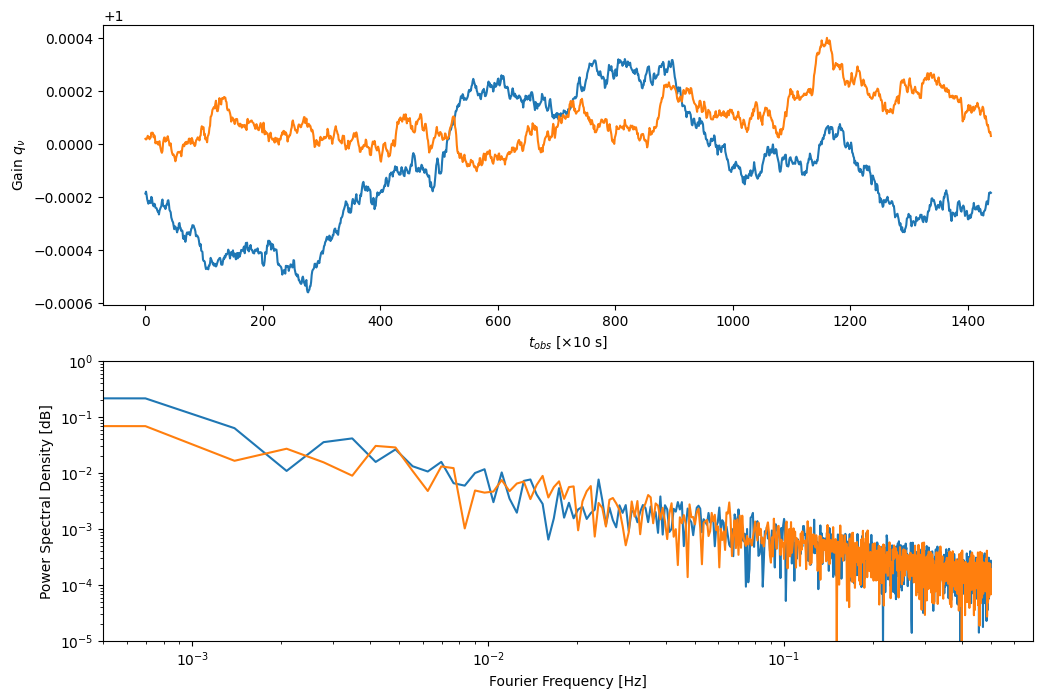

(None, None)

<Figure size 640x480 with 0 Axes>

In [41]:
fig, axs = plt.subplots(figsize=(12,8), ncols=1, nrows=2) 

axs[0].plot(np.abs(timeArray.T))
axs[0].set_xlabel(r"$t_{obs}$ [$\times 10$ s]"), axs[0].set_ylabel(r"Gain, $q_{\nu}$")

# calculate power spectra just for visualisation
fft_freq = np.fft.rfftfreq(n=timeArray.shape[-1])
pk_bn_time = np.fft.rfft(a=timeArray, axis=1)

axs[1].loglog(fft_freq, np.abs(pk_bn_time.T))
axs[1].set_xlabel(r"Fourier Frequency [Hz]"), axs[1].set_ylabel(r"Power Spectral Density [dB]")
axs[1].set_ylim(1e-5, 1.)
plt.show(), plt.clf()